### Unscented Kalman Filter: A Kalman Filter variant with better linearization technique

Unscented Kalman Filter, or UKF, is a variant of kalman filter, which uses unscented transform to linearize the non-linear model. Unscented transform, or UT, extracts representative points (popularly known as Sigma points) in a deterministic manner from the gaussian distribution and transforms these sigma points with the help of a non-linear function. The guassian distribution is recovered by calculating mean and covariance from the transformed sigma points. 

If n is the dimension of the gaussian distribution, then UT extracts $2n + 1$ number of sigma points from the distribution. Following mathematical rule is employed to extract sigma points from a given gaussian distribution. 

$$ X^{[0]} = \mu $$ <br>
$$ For\:i\:\in\:\{1,2,...,n\}$$ <br>
$$ X^{[i]} = \mu + \sqrt{(n + \lambda)}$$
$$ X^{[i + n]} = \mu - \sqrt{(n + \lambda)}$$

Where, $\mu$ vector and $\sum$ matrix are the moments of a given gaussian distribution. X is the set of sigma points. The first sigma point is always the mean vector and the remaining set of sigma points are obtained by adding and subtracting scaled column vectors of a matrix obtained by taking a square root of covariance matrix. Here, $\lambda$ is given by the following formula. 

$$ \lambda = \alpha^{2}(n + \kappa) - n $$

Where $\alpha$ and $\kappa$ are the scaling parameters, which directly influence the spread of sigma points from the mean vector. 

UKF provides accuracy upto second order Taylour series exapnasion, i.e., it will provide accuracy upto second decimal point. If the value of $\beta$ is set to 2, UKF can provide accuracy upto four decimal points. 


In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# function to plot uncertainty ellipses and sigma points
def plot_2d_gaussain(mu, cov, sigma_points, figsize = (3, 3), draw_samples = False):
    
    cov_inv = np.linalg.inv(cov)  # inverse of covariance matrix
    cov_det = np.linalg.det(cov)  # determinant of covariance matrix

    x = x = np.linspace(-5, 5)
    y = np.linspace(-5, 5)
    X,Y = np.meshgrid(x,y)
    coe = 1.0 / ((2 * np.pi)**2 * cov_det)**0.5
    Z = coe * np.e ** (-0.5 * (cov_inv[0,0]*(X-mu[0])**2 + \
                               (cov_inv[0,1] + cov_inv[1,0])*(X-mu[0])*(Y-mu[1]) + cov_inv[1,1]*(Y-mu[1])**2))
    
    sigma_points_transpose = sigma_points.T
    sigma_x = sigma_points_transpose[:,0]
    sigma_y = sigma_points_transpose[:,1]
    
    plt.figure(figsize = figsize)

    if draw_samples == True:
        sample_x, sample_y = np.random.multivariate_normal(initial_mu, initial_sigma, 1000).T
        plt.scatter(sample_x, sample_y, marker = '^', color = "yellow")
        
    plt.scatter(sigma_x, sigma_y, marker = "*", s = 200)
    plt.contour(X,Y,Z,levels = 3)
    plt.xlabel("x-axis ------>")
    plt.ylabel("y-axis ------>")
    plt.show()

In [4]:
# extract sigma points from a gaussian distribution 
def compute_sigma_points(mu, sigma, alpha, beta, kappa):
    
    n = mu.shape[0]
    sigma_points = list()
    sigma_points.append(mu)
    
    _lambda = alpha**2*(n + kappa) - n
    gamma = math.sqrt(n + _lambda)
    sqrtm_matrix = np.linalg.cholesky(gamma * sigma).T

    for i in range(n):
        sigma_points.append(mu + sqrtm_matrix[i])

    for i in range(n):
        sigma_points.append(mu - sqrtm_matrix[i])

    sigma_points = np.array(sigma_points).T
    return sigma_points

In [5]:
# Initial distribution
initial_sigma = np.array([[3,0.5],[0.5,3]])
initial_mu = np.array([1,2])
n = initial_mu.shape[0]

# Free parameters
alpha = 0.9
beta = 2
kappa = 1

In [6]:
sigma_points = compute_sigma_points(initial_mu, initial_sigma, alpha, beta, kappa)

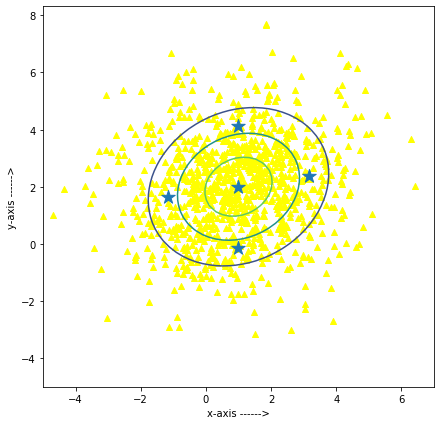

In [7]:
plot_2d_gaussain(initial_mu, initial_sigma, sigma_points, figsize = (7, 7), draw_samples = True)

### Influence of free parameters $\alpha$ and $\lambda$ on sigma points is depicted below. 

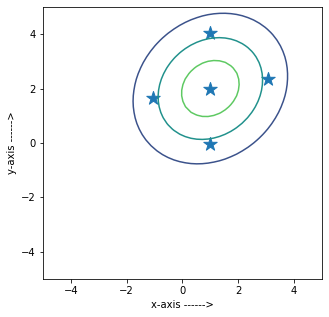

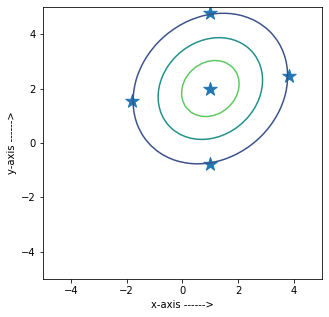

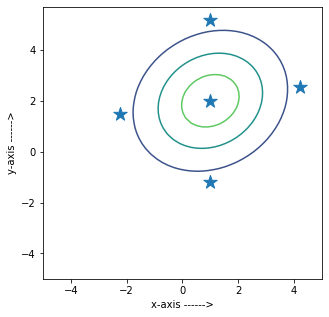

In [8]:
# Tune alpha and kappa, keep alpha constant and vary kappa
alpha_exp1 = 1
kappa_values = [0.01, 5, 10]

for i in kappa_values:
    sigma_points_exp1 = compute_sigma_points(initial_mu, initial_sigma, alpha_exp1, beta, i)
    plot_2d_gaussain(initial_mu, initial_sigma, sigma_points_exp1, figsize = (5,5), draw_samples = False)

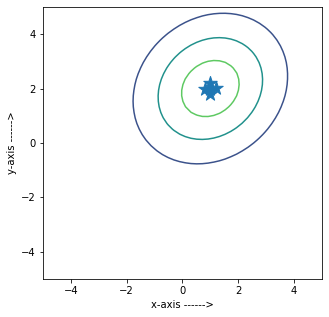

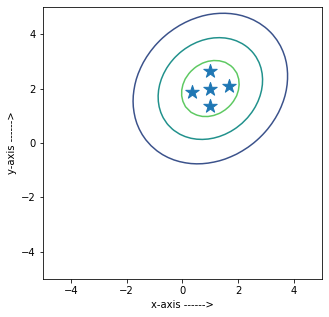

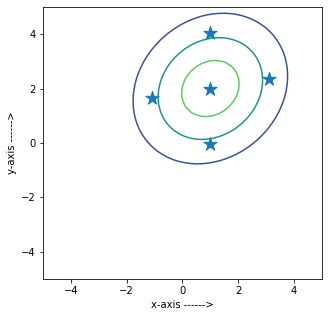

In [9]:
# Tune alpha and kappa, keep alpha constant and vary kappa
kappa_exp2 = 0.1
alpha_values = [0.01, 0.1, 1]

for i in alpha_values:
    sigma_points_exp2 = compute_sigma_points(initial_mu, initial_sigma, i, beta, kappa_exp2)
    plot_2d_gaussain(initial_mu, initial_sigma, sigma_points_exp2, figsize = (5,5), draw_samples = False)

In [10]:
class unscented_kalman_filter():
    
    def __init__(self, n, alpha, beta, kappa):
        
        self.n = n # n is the dimension of the gaussian distribution
        self.alpha = alpha # A scaling parameter
        self.beta = beta # beta is 2 for gaussian distribution
        self.kappa = kappa # A scaling parameter
        self._lambda = self.alpha**2 * (self.n + self.kappa) - self.n 
        
        self.n_sigma_points = (2 * self.n) + 1 # 2n+1 number of sigma points
        self.n_plus_lambda = self.n + self._lambda
        self.gamma = math.sqrt(self.n_plus_lambda)
        
        # weights for calculating mean vector and covariance matrix 
        self.w_m = np.zeros((2 * self.n + 1))
        self.w_c = np.zeros((2 * self.n + 1))
        
        self.w_m[0] = self._lambda / (self.n_plus_lambda) 
        self.w_m[1:] = 1 / (2 * self.n_plus_lambda)
        
        self.w_c[0] = self.w_m[0] + (1 - self.alpha**2 + self.beta)
        self.w_c[1:] = self.w_m[1]
    
    # method to display free parameters and weights
    def display_free_parameters(self):
        
        self.free_parameters = {"alpha: ": self.alpha, "beta: ": self.beta, \
                                "kappa: ": self.kappa, "lambda: ": self._lambda}
        
        print("Free parameters: \n", self.free_parameters)
        print("Weight matrix: \n", self.w_m)
        print("Weight covariance: \n", self.w_c)
        
    # method to extract sigma points from a gaussian distribution 
    def compute_sigma_points(self, mu, sigma):
        
        sigma_points = list()
        sigma_points.append(mu)
        sqrtm_matrix = np.linalg.cholesky(self.gamma * sigma).T
        
        for i in range(self.n):
            sigma_points.append(mu + sqrtm_matrix[i])
        
        for i in range(self.n):
            sigma_points.append(mu - sqrtm_matrix[i])
        
        sigma_points = np.array(sigma_points).T
        return sigma_points
    
    # method to computer mean and covariance from transformed sigma points 
    def recover_gaussian(self, sigma_points):
        
        _mu = np.zeros(self.n)
        _sigma = np.zeros((self.n, self.n))
        
        sigma_points_transpose = sigma_points.T
        
        for i in range(self.n_sigma_points):
            _mu = np.add(_mu, self.w_m[i] * sigma_points_transpose[i])

        for i in range(self.n_sigma_points):
            y_i_minus_mu = np.subtract(sigma_points_transpose[i], _mu).reshape(self.n, 1)
            _sigma = np.add(_sigma , self.w_c[i] * (y_i_minus_mu) @ (y_i_minus_mu).T)
        
        return _mu, _sigma

In [11]:
def cartesian_to_polar(sigma_points):
    
    transformed_sigma_points = list()
    sigma_points_transpose = sigma_points.T
    
    for (x, y) in sigma_points_transpose:
        r = math.sqrt(x**2 + y**2)
        theta = math.atan2(y , x)
        transformed_sigma_points.append([r, theta])
    
    transformed_sigma_points = np.array(transformed_sigma_points).T
    return transformed_sigma_points

In [12]:
def linear_transformation(sigma_points):
    
    transformed_sigma_points = list()
    sigma_points_transpose = sigma_points.T
    
    for (x, y) in sigma_points_transpose:
        x_ = x
        y_ = y
        transformed_sigma_points.append([x_, y_])
    
    transformed_sigma_points = np.array(transformed_sigma_points).T
    return transformed_sigma_points

In [18]:
ukf = unscented_kalman_filter(n, alpha, beta, kappa)
sigma_points = ukf.compute_sigma_points(initial_mu, initial_sigma)
ukf.display_free_parameters()
transformed_sigma_points = cartesian_to_polar(sigma_points)
# transformed_sigma_points = linear_transformation(sigma_points)
transformed_mu, transformed_sigma = ukf.recover_gaussian(transformed_sigma_points)

Free parameters: 
 {'alpha: ': 0.9, 'beta: ': 2, 'kappa: ': 1, 'lambda: ': 0.43000000000000016}
Weight matrix: 
 [0.17695473 0.20576132 0.20576132 0.20576132 0.20576132]
Weight covariance: 
 [2.36695473 0.20576132 0.20576132 0.20576132 0.20576132]


In [19]:
print("Sigma points: \n", sigma_points)
print("Transformed mean: ", transformed_mu)
print("Transformed cov: \n", transformed_sigma)
print("Transformed Sigma points: \n", transformed_sigma_points)

Sigma points: 
 [[ 1.          3.16253027  1.         -1.16253027  1.        ]
 [ 2.          2.36042171  4.1322836   1.63957829 -0.1322836 ]]
Transformed mean:  [2.70359618 1.02525345]
Transformed cov: 
 [[2.01826542 0.14681308]
 [0.14681308 0.61907271]]
Transformed Sigma points: 
 [[ 2.23606798  3.94628792  4.25156063  2.0098989   1.00871153]
 [ 1.10714872  0.64117467  1.33336402  2.18756517 -0.13152   ]]


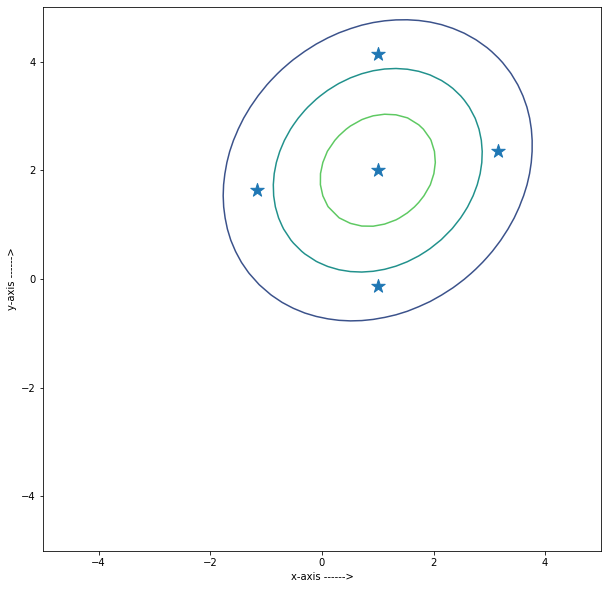

In [20]:
plot_2d_gaussain(initial_mu, initial_sigma,sigma_points, figsize = (10,10))

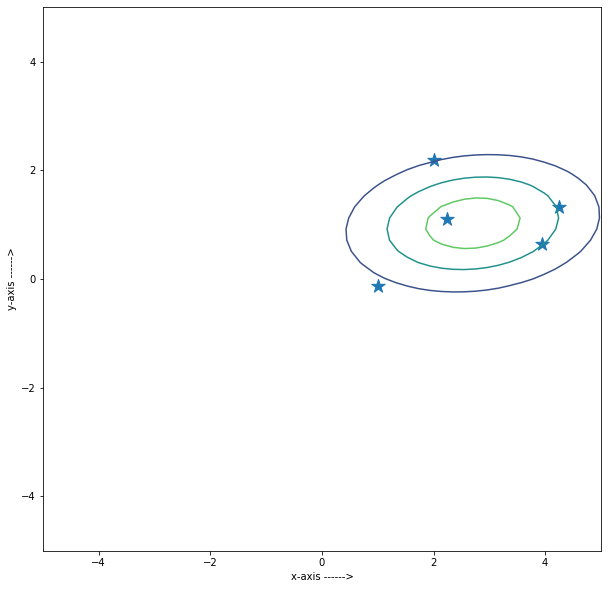

In [21]:
plot_2d_gaussain(transformed_mu, transformed_sigma, transformed_sigma_points, figsize = (10,10))

In [101]:
def normalize_angle(phi):
    # normalize phi between -pi and +pi
    while(phi > np.pi):
        phi = phi - 2 * np.pi
    
    while(phi < np.pi):
        phi = phi + 2 * np.pi
    
    return phi

R = np.array([[1,2,3],[4,5,6],[7,8,9]])
R[0:3, 0:3]

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [102]:
def prediction(mean, covariance, control_input):
    
    m, n = covariance.shape
    v = np.zeros(m)
    
    mean[0] = mean[0] + (u[1] * np.cos(mean[3] + u[0]))
    mean[1] = mean[1] + (u[1] *  np.sin(mean[3] + u[0]))
    mean[2] = mean[2] + (u[0] + u[2])
    mean[2] = normalize_angle(mean[2])
    
    G_x = np.identity((3 , 3))
    G_x[0] = -u[1] * np.cos(mean[2] + u[1])
    G_x[1] = u[1] * np.sin(mean[2] + u[1])
    
    # construct full jacobian
    G1 = np.hstack((G_x, np.zeros(3, n-3)))
    G2 = np.hstack((np.zeros(n-3, 3), np.identity(n-3)))
    G = np.vstack((G1, G2))
    
    # motion noise
    R3 = np.array([self.motion_noise, 0, 0], [0, self.motion_noise, 0], [0 , 0 , motion_noise / 10])
    R = np.zeros_like(covariance)
    R[0:3, 0:3] = R3
    
    covariance = np.add(G @ covariance @ G.T, R)
    